
# Modifying a model

Of course, a premade model may not behave in the exact way you need.
You could [make your own model](custom_models.ipynb) from scratch, but it may often be simpler to modify the properties of an existing model to match your needs.
Below we demonstrate this using the setter methods on various properties.
These methods, called on a specific element of an ``EmissionModel``, can change or add to various properties. 

First we load some common modules and a grid.

In [1]:
from unyt import dimensionless, kelvin

from synthesizer.emission_models import TotalEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Blackbody
from synthesizer.grid import Grid

# Get the grid which we'll need for extraction
grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)


## Adding a mask

We can add any number of masks to any model in the emission tree.
Below we add a filter for young stars ($< 10^7$ Myr) to the nebular components (``nebular_continuum`` and ``linecont``).
We've used the dictionary look up syntax to extract the models we want to update, and then added the mask.

In [2]:
# Make a model
model = TotalEmission(
    grid=grid,
    dust_curve=PowerLaw(slope=-1),
    tau_v=0.33,
    fesc=0.2,
    fesc_ly_alpha=0.7,
    dust_emission_model=Blackbody(temperature=100 * kelvin),
)

model["nebular_continuum"].add_mask("log10ages", "<", 7 * dimensionless)
model["linecont"].add_mask("log10ages", "<", 7 * dimensionless)

You will have seen in previous sections that we can instantiate a model with a mask, however this acts globally on all child models.
If we want to have multiple masks, we must apply them to individual models as shown above.

Notice that we have supplied units with our age threshold; this is required to maintain consistency across objects while enabling arbitrary units. 

We can see the effect of applying this mask in the emission model tree.

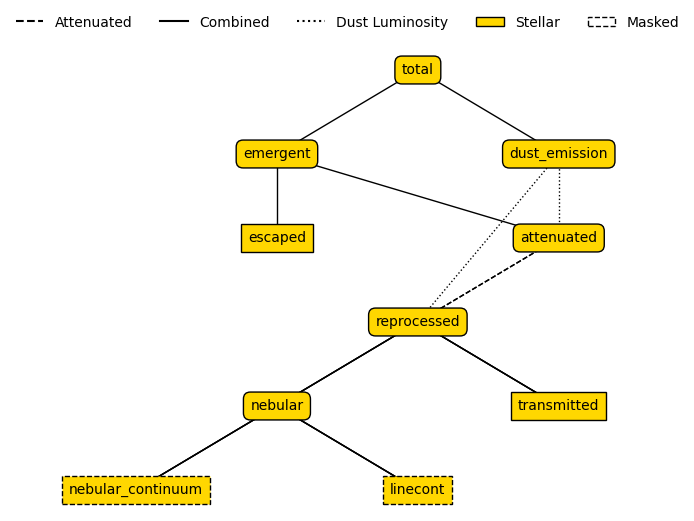

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [3]:
model.plot_emission_tree()

## Changing Properties

Any property of a model can be changed by calling its setter (any method of the form ``set_<attr>``).

For most attributes, simply index the model with the label of the child model we want to modify and call the appropriate setter.
For example, lets change the escape fraction of the nebular continuum model.

In [4]:
model["nebular_continuum"].set_fesc(0.3)
print(model)

|================================================ EmissionModel: total ===============================================|
|---------------------------------------------------------------------------------------------------------------------|
|  NEBULAR_CONTINUUM (stellar)                                                                                        |
|---------------------------------------------------------------------------------------------------------------------|
|Extraction model:                                                                                                    |
|  Grid: test_grid                                                                                                    |
|  Extract key: nebular_continuum                                                                                     |
|  Escape fraction: 0.3                                                                                               |
|  Save emission: True                  

### Changing properties on  all models

For some properties you might want to change it on every child model; these setters allow you to pass ``set_all=True``.

Here we'll swap the grid using ``set_grid``.
We just pass the same grid here for demonstration purposes, and change the grid on all extraction models.

In [5]:
model.set_grid(grid, set_all=True)

### Changing dust attenuation

To change dust properties synthesizer provides a single setter, ``set_dust_props``.
This defines the model the attenuation is applied to (``apply_dust_to``), and can optionally change a number of dust properties, such as the ``dust_curve`` and the `tau_v`.


In [6]:
model["attenuated"].set_dust_props(
    dust_curve=PowerLaw(slope=-0.7),
    apply_dust_to=model["reprocessed"],
    tau_v=0.7,
)

## Replacing models

Instead of changing the properties we can also completely replace a model with one or more models.

Below we swap out the attenuation model with two separate attenuation models, which apply different dust curves to the old and young stellar populations (for more information on defining your own models see the [custom model docs](custom_models.ipynb)).

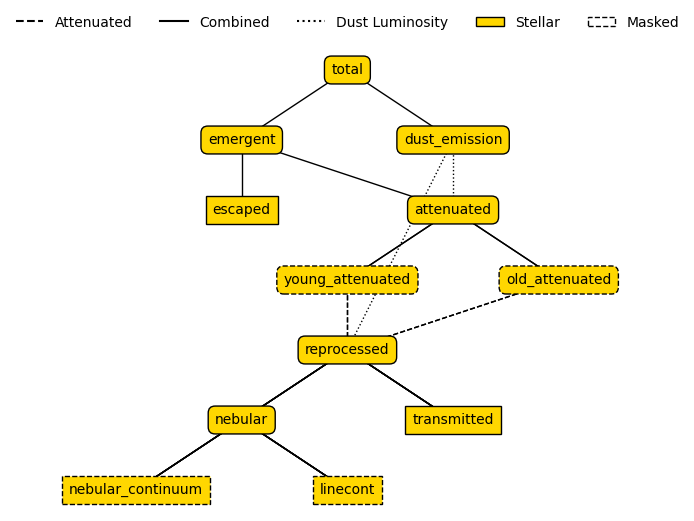

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [7]:
from synthesizer.emission_models import EmissionModel

# Define the models well replace attenuate with
young_attenuated = EmissionModel(
    "young_attenuated",
    dust_curve=PowerLaw(slope=-1),
    apply_dust_to=model["reprocessed"],
    tau_v=0.7,
    mask_attr="log10ages",
    mask_thresh=7 * dimensionless,
    mask_op="<=",
    emitter="stellar",
)
old_attenuated = EmissionModel(
    "old_attenuated",
    dust_curve=PowerLaw(slope=-1),
    apply_dust_to=model["reprocessed"],
    tau_v=0.7 * 0.67,
    mask_attr="log10ages",
    mask_thresh=7 * dimensionless,
    mask_op=">",
    emitter="stellar",
)

model.replace_model("attenuated", young_attenuated, old_attenuated)
model.plot_emission_tree()

Notice how passing multiple models after the label has also introduced a combination model using the original label. Had we only passed a single model this would have instead replaced the model entirely.

## Relabel model

To change the label associated to a model we can use the ``relabel`` method. 

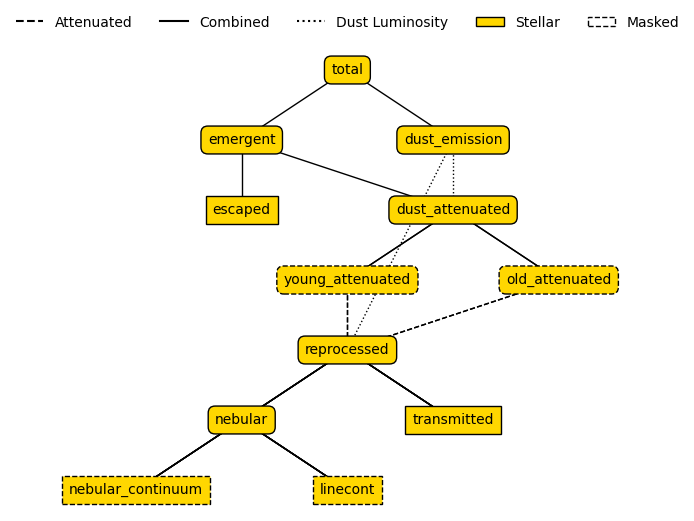

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [8]:
model.relabel("attenuated", "dust_attenuated")
model.plot_emission_tree()

## Fixing parameters

When an emission model is used in a ``get_spectra`` method any parameters the model does not define will be extracted from the emitter. If you would like to give any of the values fixed values you can use the ``fix_parameters`` setter. This can also be done at instantiation (see the custom models [docs](custom_models.ipynb)).

In [9]:
model["dust_attenuated"].fix_parameters(tau_v=0.67)